In [116]:
%matplotlib inline

from perf_plotter import get_filtered_data, flatten, get_diffs, __compare, rgetattr
import data_parser
import argparse
import plot_styles as ps
import matplotlib.pyplot as plt
import general_plotting as gp
import numpy as np
import os
import pickle
from optionloop import OptionLoop
from collections import defaultdict

In [2]:
run = data_parser.run
rundata = data_parser.rundata
data = None
try:
    with open(os.path.join('.', 'data.pickle'), 'rb') as file:
        data = pickle.load(file)
except:
    pass
finally:
    if data is None:
        data = data_parser.parse_data()
        with open(os.path.join('.', 'data.pickle'), 'wb') as file:
            pickle.dump(data, file)
            
mechs = data.keys()

In [202]:
def separate(data, plot_type='runtime', norm=True, **pwkwds):
    diffs, locs, check = get_diffs(flatten(data))
    oploop = OptionLoop({check[locs[i]]: list(diffs[i]) for i in range(len(locs))})
    rv = []
    for state in oploop:
        subdata = get_filtered_data(data, warn=False, strict=True, **state)
        subdata = flatten(subdata)
        if not subdata:
            continue
        x, y, z = gp.process_data(subdata, plot_type, **pwkwds)
        # get the part of the subdata that is identical across all for later ident.
        sd, _, sc = get_diffs(subdata)
        # and store
        same = {c: rgetattr(subdata[0], c) for c in sc if sc not in sd}
        rv.append((same, (np.array(x), np.array(y), np.array(z)), subdata))
    return rv

In [217]:
def combine(datalist):
    combined = defaultdict(lambda: [])
    for data in datalist:
        for mech in data:
            combined[mech].extend(data[mech])

    return combined

In [203]:
class normalizer(object):
    def __init__(self, key):
        self.ymax = defaultdict(lambda: None)
        self.key = key
    
    def __getitem__(self, state):
        if self.key is None:
            return self.ymax['default']
        return self.ymax[state[self.key]]

    def __setitem__(self, state, value):
        if self.key is None:
            self.ymax['default'] = value
        else:
            self.ymax[state[self.key]] = value

In [204]:
def normalize_per_key(data, key):
    # normalize pre-separated data per a given key in the data
    # first pass -- get y max per x
    ymax = normalizer(key)
    for state, (x, y, z), _ in data:
        if ymax[state] is None:
            ymax[state] = y[:]
        ymax[state] = np.maximum(y, ymax[state])
        
    # second pass -- normalize y & z
    for i in range(len(data)):
        state = data[i][0]
        x, y, z = data[i][1]
        z = (z / y) * (ymax[state] / y)
        y = ymax[state] / y
        data[i] = (state, (x, y, z), data[i][2])
   
    return data

In [205]:
def normalize_per_mech(data):
    # normalize pre-separated data per mechanism
    return normalize_per_key(data, None)

In [206]:
def plot(data, namefunc, markerfunc, norm=None):
    sep = separate(data)
    if norm is not None:
        sep = norm(sep)
    plot_ind = 0
    for state, subdata, _  in sep:
        gp.plot('runtime', *subdata, label=namefunc(state), marker=markerfunc(state), plot_ind=plot_ind)
        plot_ind +=1

In [207]:
def pretty_name(state, key):
    return ps.pretty_names(key).format(state[key])

In [208]:
def plot_data_standard(data, namefunc, marker_func, labels, ylog=False, xlog=False,
                       limits={}, norm=None):
    plot(data, namefunc, marker_func, norm=norm)
    plt.xlabel(labels['x'])
    plt.ylabel(labels['y'])
    plt.title(labels['title'])
    if 'x' in limits:
        plt.gca().set_xlim(limits['x'])
    if 'y' in limits:
        plt.gca().set_ylim(limits['y'])
    if ylog:
        plt.gca().set_yscale('log')
    if xlog:
        plt.gca().set_xscale('log')
    plt.legend(loc=0)
    ps.finalize()
    plt.show()

In [209]:
class compound_namer(object):
    def __init__(self):
        self.name = ''
    
    def add_key(self, state, key):
        if key in state:
            if self.name:
                self.name += ' - '
            self.name += pretty_name(state, key)
        return self.name
            
    def add_keys(self, state, keys):
        for key in keys:
            self.add_key(state, key)
        return self.name

In [ ]:
class marker_dict(object):
    def __init__(self, color_dict_list, marker_key, marker_dict_list):
        self.color_dict = {}
        for (key, cdict) in color_dict_list:
            self.color_dict[key] = cdict
            
        self.marker_dict = {}
        for (key, cdict) in marker_dict_list:
            self.marker_dict[key] = cdict  
            
    def __call__(state):
        marker = self.marker_dict[]

In [220]:
# common labels
reac_label = r'Runtime (\si{\milli\second} / state)'
speedup_label = r'Speedup'
runtime_label = r'Runtime (\si{\milli\second} / state)'

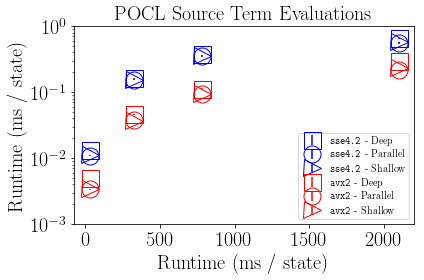

In [221]:
# begin source term plots
#1 POCL equivalency over all type

filtered = get_filtered_data(
    data, platform='portable',
    vectype=lambda x: x in ['w', 'd', 'par'],
    cores='1',
    order='C',
    conp='conp',
    vecwidth='8',
    descriptor=lambda x: x in ['srv2', 'haswell'],
    rtype='spec',
    rates='hybrid')

def namer(state):
    return '{} - {}'.format(
        pretty_name(state, 'descriptor'),
        pretty_name(state, 'vectype')
    )

def marker(state):
    color_map = {'srv2': 'b',
                 'haswell': 'r'}
    marker_map = {'w': '>',
                  'd': 's',
                  'par': 'o'}
    return marker_map[state['vectype']], True, color_map[state['descriptor']]

plot_data_standard(filtered, namer, marker, {
    'x': reac_label,
    'y': runtime_label,
    'title': 'POCL Source Term Evaluations'},
    ylog=True,
    limits={'y': [1e-3, 1e0]})

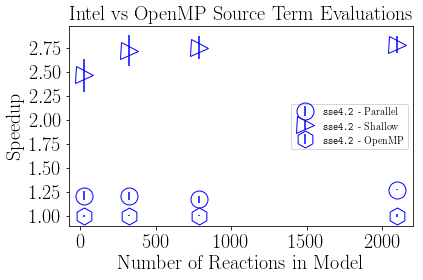

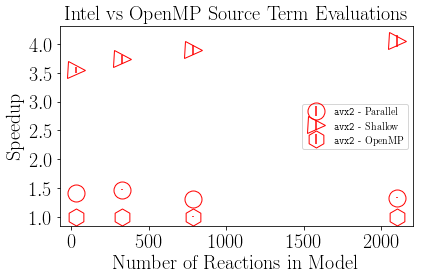

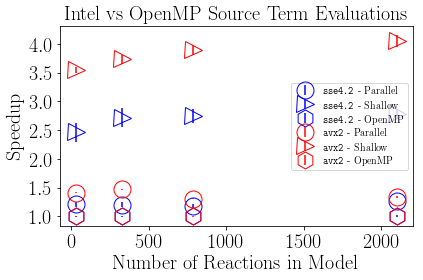

In [211]:
# next intel vs OpenMP

def __get_data(desc):
    return get_filtered_data(
    data,
    lang=lambda x: x in ['opencl', 'c'],
    platform=lambda p: p in ['None', 'intel', 'False'],
    vectype=lambda x: x in ['w', 'par'],
    cores='1',
    order='C',
    conp='conp',
    vecwidth='8',
    descriptor=lambda x: x in desc,
    rtype='spec',
    rates='hybrid')

def c_or_opencl_marker(state):
    color_map = {'srv2': 'b',
                 'haswell': 'r'}
    ocl_marker_map = {'w': '>',
                      'd': 's',
                      'par': 'o'}
    c_marker_map = {'par': 'h'}
    marker_map = ocl_marker_map if state['lang'] == 'opencl' else c_marker_map
    return marker_map[state['vectype']], True, color_map[state['descriptor']]

def c_or_opencl_namer(state):
    namer = compound_namer()
    keys = ['descriptor'] + ['vectype' if state['lang'] == 'opencl' else 'lang']
    return namer.add_keys(state, keys)

plot_data_standard(__get_data(['srv2']), c_or_opencl_namer, c_or_opencl_marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=normalize_per_mech)

plot_data_standard(__get_data(['haswell']), c_or_opencl_namer, c_or_opencl_marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=normalize_per_mech)

plot_data_standard(__get_data(['haswell', 'srv2']), c_or_opencl_namer, c_or_opencl_marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=lambda data: normalize_per_key(data, 'descriptor'))

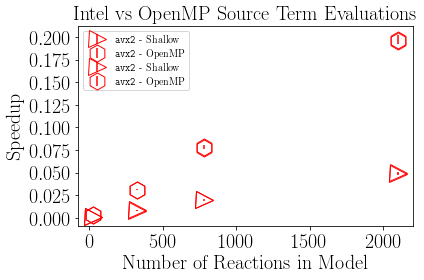

In [219]:
# conp vs conv
# next intel vs OpenMP

filtered_ocl = get_filtered_data(
    data,
    lang='opencl',
    platform='intel',
    vectype='w',
    cores='1',
    order='C',
    vecwidth='8',
    descriptor='haswell',
    rtype='spec',
    rates='hybrid')

filtered_c = get_filtered_data(
    data,
    lang='c',
    vectype='par',
    cores='1',
    order='C',
    vecwidth='8',
    descriptor='haswell',
    rtype='spec',
    rates='hybrid')

filtered = combine([filtered_ocl, filtered_c])

plot_data_standard(filtered, c_or_opencl_namer, c_or_opencl_marker, {
    'x': reac_label,
    'y': runtime_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'})